Name: Nathan Dang

Partner: Charlie Poff-Webster

Date: 03/10/2020

DSCI225 - Applied Machine Learning

Intructor: Prof. Basye

# Lab 4 - ML on a computational budget

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Timing code

(borrowed from https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python)

In [2]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start
    


In [3]:
with elapsed_timer() as my_timer:
    sum = 0
    for x in range(1000000):
        sum += x
    print(my_timer())
    for x in range(1000000):
        sum += x
     
print(my_timer())

0.0914263999999998
0.1789152999999999


# MNIST

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X[0]
X_train.shape

(60000, 784)

# Multiclass classification

## SVC vs OneVsRestClassifiers

We wrapped the training for the SVC and OneVsRestClassifiers in timing constructs so as to see how long they take. Then we conducted some experiments in which we tried successively larger amounts of training data, doubling the size a few times to get a sense of the underlying complexity.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [9]:
# sizes = [1000, 2000, 4000, 8000, 16000]
sizes = [1000, 2000, 4000]

from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)
for size in sizes:
    with elapsed_timer() as svc_timer:
        svm_clf.fit(X_train[:size], y_train[:size])
    print("for size of " + str(size) + f" svm_clf.fit took {svc_timer():.3f} secs")
svm_clf.predict([some_digit])

for size of 1000 svm_clf.fit took 1.555 secs
for size of 2000 svm_clf.fit took 6.110 secs
for size of 4000 svm_clf.fit took 26.232 secs


array([5], dtype=uint8)

In [10]:
# sizes = [1000, 2000, 4000, 8000, 16000]
sizes = [1000, 2000, 4000]

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
for size in sizes:
    with elapsed_timer() as ovr_timer:
        ovr_clf.fit(X_train[:size], y_train[:size])
    print("for size of " + str(size) + f" ovr_clf.fit took {ovr_timer():.3f} secs")
ovr_clf.predict([some_digit])

for size of 1000 ovr_clf.fit took 9.072 secs
for size of 2000 ovr_clf.fit took 34.573 secs
for size of 4000 ovr_clf.fit took 131.269 secs


array([5], dtype=uint8)

In [11]:
len(ovr_clf.estimators_)

10

<b>Observation:</b> One Vs Rest Classifier takes longer to finish than Support Vector Classifier and the time taken grows significantly as we doubled the training size. We did experiment with the size up to 16000 but then it will take more than three hours to finish so we decided to put it aside for now and only do some runs with size up to 4000.

## SGD Classifier

We used the fitting time, the cross_val of accuracy, and the confusion matrix to evaluate our results for part 1 & 2

In [12]:
with elapsed_timer() as sgd_timer_original:
    sgd_clf.fit(X_train, y_train)
print("For the original dataset " + f"sgd_clf.fit took {sgd_timer_original():.3f} secs")
sgd_clf.predict([some_digit])

For the original dataset sgd_clf.fit took 120.341 secs


array([3], dtype=uint8)

In [13]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [14]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

E:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

E:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

## KNN classifier

We used the fitting time, the predicting time, and the accuracy to evaluate our results for part 1 & 2

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
with elapsed_timer() as knn_fit_original:
    knn_clf.fit(X_train, y_train)
print("For the original dataset " + f"knn_clf.fit took {knn_fit_original():.3f} secs")

For the original dataset knn_clf.fit took 13.341 secs


In [18]:
with elapsed_timer() as knn_predict_original:
    y_knn_pred = knn_clf.predict(X_test)
print("For the original dataset " + f"knn_clf.predict took {knn_predict_original():.3f} secs")

For the original dataset knn_clf.predict took 627.506 secs


In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

# Speeding Things Up, pt. 1

## Part 1a

Consider the image on p. 199 of the book (or find the same in the notebook for chapter 7). This suggests that maybe we could train and predict on a smaller image and still do pretty well. We began by just removing pixels around the edges of the image.

In [20]:
# initialise the cropped training and test set
X_train_reshape = np.zeros((60000, 484)) # 22*22 = 484
X_test_reshape = np.zeros((10000, 484))

def plot_digit(data):
    plt.figure(figsize=(5, 5))
    plt.subplot(121)
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")
    
    plt.subplot(122)
    image = data.reshape(28, 28)
    plt.imshow(image[4:26,4:26], cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

def crop_data(data, row_index, train_vs_test):
    image = data.reshape(28, 28)
    if train_vs_test:
        X_train_reshape[row_index] = np.reshape(image[4:26, 4:26], (484,))
    else:
        X_test_reshape[row_index] = np.reshape(image[4:26, 4:26], (484,))

Here is the visualisation of a few digits before and after cropping a few pixels around the edges

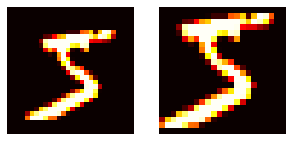

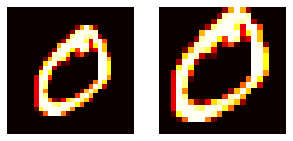

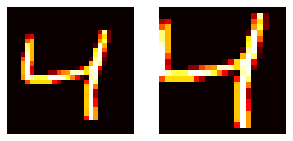

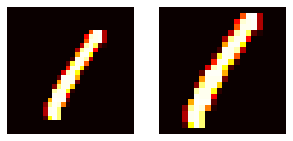

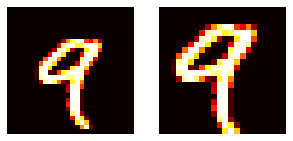

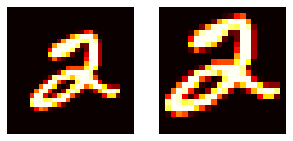

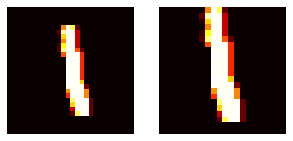

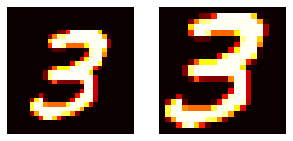

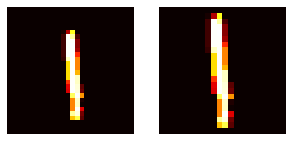

In [21]:
for i in range(0, 9):
    plot_digit(X_train[i])
    plt.show()

# cropping the traning images
for i in range(0, 60000):
    crop_data(X_train[i], i, True)
    
# cropping the test images
for i in range(0, 10000):
    crop_data(X_test[i], i, False)

Examine the result with SGD Classifier

In [22]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
with elapsed_timer() as sgd_timer_cropped:
    sgd_clf.fit(X_train_reshape, y_train)
print("For the cropped dataset " + f"sgd_clf.fit took {sgd_timer_cropped():.3f} secs")

For the cropped dataset sgd_clf.fit took 86.497 secs


In [23]:
cross_val_score(sgd_clf, X_train_reshape, y_train, cv=3, scoring="accuracy")

array([0.87792442, 0.87989399, 0.86863029])

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_reshape_scaled = scaler.fit_transform(X_train_reshape.astype(np.float64))
cross_val_score(sgd_clf, X_train_reshape_scaled, y_train, cv=3, scoring="accuracy")

array([0.88467307, 0.87579379, 0.88088213])

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_reshape_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5524,    0,   17,    4,    6,   39,   20,    6,  306,    1],
       [   1, 6387,   30,   16,    3,   33,    1,    6,  258,    7],
       [  25,   25, 5122,   69,   66,   31,   48,   37,  528,    7],
       [  22,   13,  103, 5120,    2,  171,   17,   36,  586,   61],
       [   9,   11,   32,   10, 5070,    9,   20,   15,  516,  150],
       [  24,   14,   21,  146,   48, 4328,   60,   11,  716,   53],
       [  29,   11,   34,    1,   46,   76, 5350,    5,  364,    2],
       [  22,    7,   46,   14,   48,   15,    4, 5596,  343,  170],
       [  19,   57,   36,   90,    3,  119,   20,    6, 5472,   29],
       [  21,   19,   27,   61,  123,   28,    1,  169,  642, 4858]],
      dtype=int64)

Examine the result with KNN Classifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
with elapsed_timer() as knn_fit_cropped:
    knn_clf.fit(X_train_reshape, y_train)
print("For the cropped dataset " + f"knn_clf.fit took {knn_fit_cropped():.3f} secs")

For the cropped dataset knn_clf.fit took 10.582 secs


In [27]:
with elapsed_timer() as knn_predict_cropped:
    y_knn_pred = knn_clf.predict(X_test_reshape)
print("For the cropped dataset " + f"knn_clf.predict took {knn_predict_cropped():.3f} secs")

For the cropped dataset knn_clf.predict took 402.878 secs


In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9712

<b>Observation:</b> for both KNN and SGD Classifier we can clearly see that the running time has improved (not much, but noticeable) for fitting and predicting after cropping some of the border pixels which are clearly not important for our classifier whilst mantaining a pretty much the same accuracy. 

## Part 1b

At this point, we tried the same thing but used the importance values generated by the Random Forest Classifier and performed masking to keep only the valuable values. The purpose is to see if it yields a better timing whilst maintaining the same performance.

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [30]:
import numpy.ma as ma

def plot_digit_combined_mask(data, threshold):
    plt.subplot(121)
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")
    
    plt.subplot(122)
    mask_array = []
    for i in data:
        if i <= threshold:
            mask_array.append(1)
        else:
            mask_array.append(0)
            
    image_mask = ma.masked_array(data.reshape(28, 28), mask_array)
    plt.imshow(image_mask, cmap = mpl.cm.hot, interpolation="nearest")  
    plt.title("Threshold: " + str(threshold))
    plt.axis("off")

def mask_data(feature_importances, threshold):
    mask_array = []
    for i in feature_importances:
        if i <= threshold:
            mask_array.append(1)
        else:
            mask_array.append(0)
    return mask_array

The following is the visualisation of the feature importances before and after performing the masking, we selected a few threshold values.

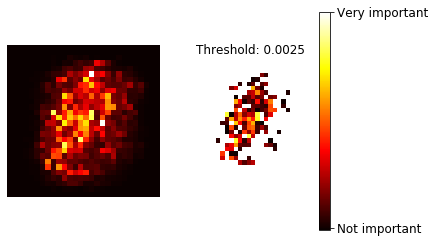

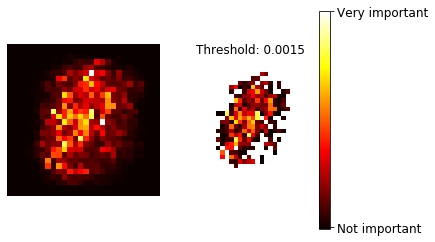

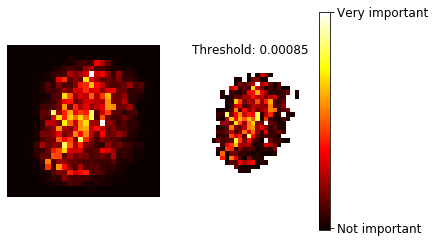

In [31]:
thresholds = [.0025, .0015, .00085]

for threshold in thresholds:
    plot_digit_combined_mask(rnd_clf.feature_importances_, threshold)   
    cbar = plt.colorbar(ticks=[threshold+0.0001, rnd_clf.feature_importances_.max()])
    cbar.ax.set_yticklabels(['Not important', 'Very important'])
    plt.show()

Masking the data with a given threshold

In [32]:
X_train_masked = []
X_test_masked = []

In [33]:
threshold = 0.0025

mask_array = mask_data(rnd_clf.feature_importances_, threshold)

# masking the traning images
for i in range(0, 60000):
    X_train_masked.append(ma.masked_array(X_train[i], mask_array))
    
# masking the test images
for i in range(0, 10000):
    X_test_masked.append(ma.masked_array(X_test[i], mask_array))

Compressing the images by getting rid of all masked value

In [34]:
X_train_masked_reshape = []
X_test_masked_reshape = []

In [35]:
for i in range(0, 60000):
    X_train_masked_reshape.append(ma.compressed(X_train_masked[i]))
    
for i in range(0, 10000):
    X_test_masked_reshape.append(ma.compressed(X_test_masked[i]))
    
X_train_masked_matrix = np.asmatrix(X_train_masked_reshape)
X_test_masked_matrix = np.asmatrix(X_test_masked_reshape)

In [36]:
print(X_train_masked_matrix.shape)
print(X_test_masked_matrix.shape)

(60000, 139)
(10000, 139)


Examine the result with SGD Classifier

In [37]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
with elapsed_timer() as sgd_timer_masked:
    sgd_clf.fit(X_train_masked_matrix, y_train)
print("For the masked dataset " + f"sgd_clf.fit took {sgd_timer_masked():.3f} secs")

For the masked dataset sgd_clf.fit took 37.406 secs


In [38]:
cross_val_score(sgd_clf, X_train_masked_matrix, y_train, cv=3, scoring="accuracy")

array([0.80393921, 0.81374069, 0.82327349])

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_masked_matrix_scaled = scaler.fit_transform(X_train_masked_matrix.astype(np.float64))
cross_val_score(sgd_clf, X_train_masked_matrix_scaled, y_train, cv=3, scoring="accuracy")

array([0.86562687, 0.85939297, 0.86017903])

In [40]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_masked_matrix_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5425,    0,  104,   51,    5,  166,   20,    8,  117,   27],
       [   2, 6308,   85,   65,    2,  104,    3,   10,  139,   24],
       [  52,   67, 5077,  120,   88,   59,  170,   70,  192,   63],
       [  29,   31,  200, 5096,    4,  444,   13,   46,  153,  115],
       [   9,   13,  140,   37, 4975,  115,   37,   11,  184,  321],
       [  52,   24,  112,  245,   61, 4464,  111,   19,  223,  110],
       [  41,   13,  187,   38,   39,  239, 5163,   10,  170,   18],
       [  33,   24,  217,   49,   56,   60,    3, 5526,   51,  246],
       [   9,   78,  167,  227,   20,  334,   38,   14, 4773,  191],
       [  13,   30,  107,  126,  213,  203,    1,  222,  137, 4897]],
      dtype=int64)

Examine the result with KNN Classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
with elapsed_timer() as knn_fit_masked:
    knn_clf.fit(X_train_masked_matrix, y_train)
print("For the masked dataset " + f"knn_clf.fit took {knn_fit_masked():.3f} secs")

For the masked dataset knn_clf.fit took 5.323 secs


In [42]:
with elapsed_timer() as knn_predict_masked:
    y_knn_pred = knn_clf.predict(X_test_masked_matrix)
print("For the masked dataset " + f"knn_clf.predict took {knn_predict_masked():.3f} secs")

For the masked dataset knn_clf.predict took 130.027 secs


In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9611

<b>Observation:</b> For both SGD and KNN Classifier, we can see that compressing the images using the feature importance values improves the run-time significantly whilst mantaining a very good (but slightly lower) accuracy.

# Speeding Things Up, pt. 2

For this part, we used PCA to reduce the dimensionality of the space. Then we tried the reduction that preserves just more than 80% of the variance and see how that performs in terms of accuracy.

First, we reduced the input space to 139 components, the same from part 1b (we didn't reduce to 484 components like part 1a for the sake of simplicity in terms of running the whole notebook again).

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 139)
X_reduced = pca.fit_transform(X)

In [46]:
X_train_reduced, X_test_reduced, y_train, y_test = X_reduced[:60000], X_reduced[60000:], y[:60000], y[60000:]

In [47]:
pca.n_components_

139

Examine the result with SGD Classifier

In [48]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
with elapsed_timer() as sgd_timer_reduced:
    sgd_clf.fit(X_train_reduced, y_train)
print("For the reduced dataset " + f"sgd_clf.fit took {sgd_timer_reduced():.3f} secs")

For the reduced dataset sgd_clf.fit took 21.239 secs


In [49]:
cross_val_score(sgd_clf, X_train_reduced, y_train, cv=3, scoring="accuracy")

array([0.87312537, 0.86669333, 0.88393259])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced.astype(np.float64))
cross_val_score(sgd_clf, X_train_reduced_scaled, y_train, cv=3, scoring="accuracy")

array([0.89967007, 0.89854493, 0.90698605])

In [51]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_reduced_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5589,    1,   60,   33,    7,   96,   35,    7,   87,    8],
       [   2, 6443,   55,   33,    7,   48,    4,   14,  115,   21],
       [  31,   54, 5283,  124,   63,   51,   78,   80,  171,   23],
       [  22,   18,  173, 5366,    6,  242,   24,   48,  151,   81],
       [   9,   11,   57,   18, 5369,   24,   35,   15,   87,  217],
       [  50,   19,   85,  248,   70, 4554,  112,   30,  174,   79],
       [  36,   10,   74,   11,   32,  113, 5562,   10,   65,    5],
       [  19,   18,   96,   40,   64,   20,    2, 5792,   41,  173],
       [  28,   79,  110,  203,   39,  278,   36,   19, 4962,   97],
       [  16,   17,   36,  105,  204,   70,    0,  204,  113, 5184]],
      dtype=int64)

Examine the result with KNN Classifier

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
with elapsed_timer() as knn_fit_reduced:
    knn_clf.fit(X_train_reduced, y_train)
print("For the reduced dataset " + f"knn_clf.fit took {knn_fit_reduced():.3f} secs")

For the reduced dataset knn_clf.fit took 0.602 secs


In [53]:
with elapsed_timer() as knn_predict_reduced:
    y_knn_pred = knn_clf.predict(X_test_reduced)
print("For the reduced dataset " + f"knn_clf.predict took {knn_predict_reduced():.3f} secs")

For the reduced dataset knn_clf.predict took 97.396 secs


In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9734

<b>Observation:</b> for both SGD and KNN Classifier, we can see that the running time imporved quite a lot compared to that of part 1b whilst maintaining a good accuracy.

Finally, we tried the reduction that preserves just more than 80% of the variance and examined accuracy.

In [55]:
pca = PCA(n_components=0.80)
X_reduced_80 = pca.fit_transform(X)

In [56]:
X_train_reduced_80, X_test_reduced_80, y_train, y_test = X_reduced_80[:60000], X_reduced_80[60000:], y[:60000], y[60000:]

In [57]:
pca.n_components_

43

Examine the result using SGD Classifier

In [58]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_reduced_80, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
cross_val_score(sgd_clf, X_train_reduced_80, y_train, cv=3, scoring="accuracy")

array([0.85837832, 0.85729286, 0.85697855])

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_reduced_scaled_80 = scaler.fit_transform(X_train_reduced_80.astype(np.float64))
cross_val_score(sgd_clf, X_train_reduced_scaled_80, y_train, cv=3, scoring="accuracy")

array([0.88382324, 0.88144407, 0.88493274])

In [61]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_reduced_scaled_80, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5694,    1,   24,   19,   10,   49,   49,   14,   55,    8],
       [   2, 6490,   43,   24,    7,   55,    6,   15,   87,   13],
       [  35,   38, 5088,  108,  143,   47,  135,  119,  189,   56],
       [  26,   17,  217, 5120,   15,  330,   49,   72,  172,  113],
       [  16,   19,   48,    7, 5250,   29,   58,   17,   79,  319],
       [  89,   28,   67,  210,  130, 4365,  143,   49,  220,  120],
       [  35,   10,   58,    7,   60,  101, 5579,   10,   52,    6],
       [  35,   28,  114,   39,   85,   28,    7, 5692,   27,  210],
       [  63,  126,   92,  200,   51,  317,   65,   36, 4778,  123],
       [  37,   48,   38,  115,  262,  106,    7,  274,  114, 4948]],
      dtype=int64)

Examine the result using KNN Classifier

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train_reduced_80, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [63]:
y_knn_pred = knn_clf.predict(X_test_reduced_80)

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9764

<b>Observation:</b> we can see that the accuracy scores of both SGD and KNN Classifier are slightly worse than those of the model above which is somewhat understandable as the PCA only preserves around 80% of the variance.

<b>In Summary:</b> if we did nothing wrong, then we can conclude that the PCA has the best performance in terms of speeding up the learning process whilst maintaining a good accuracy score compared to the other methods in part 1. Utilising the feature importance values was pretty good in terms of dealing with the MNIST dataset so we guess that it will also do well for similar problems. Lastly, we see that lowering the percentage of variance that we want the PCA to preserve surely will boost the speed quite a lot but it will definitely hurt the performance in terms of accuracy (and maybe other score types as well). And this is a wrap up for our lab 4 :) 